In [0]:
import os
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from sklearn import metrics as met
from sklearn import model_selection as ms

%matplotlib inline
#plt.style.use ('dark_background')


Using TensorFlow backend.


In [0]:
! rm -R CNN_SLIKE
! rm -R Hey-Waldo
! rm -R SLIKE_AUG
! rm -R ml03-finding-wally
! rm -R Cekpointi

! git clone https://github.com/vc1492a/Hey-Waldo.git
! git clone https://github.com/matf-ml/ml03-finding-wally.git

! mkdir CNN_SLIKE
! mkdir CNN_SLIKE/waldo
! mkdir CNN_SLIKE/Waldo_transparent_64_64
! mv Hey-Waldo/64/notwaldo CNN_SLIKE
! mv ml03-finding-wally/data/Slike/Waldo_transparent CNN_SLIKE
! mkdir Cekpointi

rm: cannot remove 'CNN_SLIKE': No such file or directory
rm: cannot remove 'Hey-Waldo': No such file or directory
rm: cannot remove 'SLIKE_AUG': No such file or directory
rm: cannot remove 'ml03-finding-wally': No such file or directory
rm: cannot remove 'Cekpointi': No such file or directory
Cloning into 'Hey-Waldo'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 18808 (delta 0), reused 1 (delta 0), pack-reused 18807
Receiving objects: 100% (18808/18808), 112.65 MiB | 26.82 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Checking out files: 100% (20839/20839), done.
Cloning into 'ml03-finding-wally'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 382 (delta 1), reused 32 (delta 1), pack-reused 347
Receiving objects: 100% (382/382), 179.23 MiB | 30.18 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [0]:
# Smanjivanje slika transparentnog Walda na 64x64

gcolab_putanja_notwaldo = os.path.join ('CNN_SLIKE', 'notwaldo')
gcolab_putanja_waldo = os.path.join ('CNN_SLIKE', 'waldo')
gcolab_putanja_transp = os.path.join ('CNN_SLIKE', 'Waldo_transparent')
gcolab_putanja_transp_64 = os.path.join ('CNN_SLIKE', 'Waldo_transparent_64_64')

slike_transp = [os.path.join(gcolab_putanja_transp, f) for f in os.listdir(gcolab_putanja_transp) if os.path.isfile(os.path.join(gcolab_putanja_transp, f))]

# Slika sa Waldom smanjujemo na 64x64

size = (64, 64, 4)
i = 1

for slika in slike_transp:
    
    ime = '%d.png' % i
    izlazna_putanja = os.path.join ('CNN_SLIKE', 'Waldo_transparent_64_64', ime)
    i += 1
    
    if slika != izlazna_putanja:
        try:
            im = Image.open (slika)
            im.thumbnail(size, Image.ANTIALIAS)
            im.save(izlazna_putanja, "PNG")
            
        except IOError:
            print ("Greska pri kreiranju '%s'" % slika)


In [0]:
# Lepljenje transparentnih slika sa likom Walda na slike iz notwaldo skupa

# Iteriramo kroz notwaldo slike i lepimo na njih transparentnog walda

slike_transp_64 = [os.path.join(gcolab_putanja_transp_64, f) for f in os.listdir(gcolab_putanja_transp_64) if os.path.isfile(os.path.join(gcolab_putanja_transp_64, f))]
slike_notwaldo = [os.path.join(gcolab_putanja_notwaldo, f) for f in os.listdir(gcolab_putanja_notwaldo) if os.path.isfile(os.path.join(gcolab_putanja_notwaldo, f))]

i = 0
num_generated_files = 0
for slika_1 in slike_notwaldo:
    
    pozadina = Image.open(slika_1).convert('RGBA')
    
    # Kroz Waldo slike idemo ciklicno i lepimo redom
    valdo_slika = Image.open(slike_transp_64 [i % len(slike_transp_64)]).convert('RGBA')
    
    poz_1 = random.randrange (0, pozadina.size[0] - valdo_slika.size[0] + 1, 1)
    poz_2 = random.randrange (0, pozadina.size[1] - valdo_slika.size[1] + 1, 1)
    
    pozadina.paste(valdo_slika, (poz_1, poz_2), valdo_slika)
    
    new_file_path = '%s/aug_%s.jpeg' % (gcolab_putanja_waldo, num_generated_files)
    pozadina.convert('RGB').save(new_file_path, "JPEG")
    
    num_generated_files += 1
    i += 1


In [0]:
! rm -R SLIKE_AUG
! mkdir SLIKE_AUG
! mkdir SLIKE_AUG/waldo
! mkdir SLIKE_AUG/notwaldo

In [0]:
# Koriscenje ugradjene funkcije za generisanje novih podataka

gcolab_waldo_ulaz = os.path.join ('CNN_SLIKE')
gcolab_notwaldo_ulaz = os.path.join ('CNN_SLIKE')
gcolab_waldo_izlaz = os.path.join ('SLIKE_AUG', 'waldo')
gcolab_notwaldo_izlaz = os.path.join ('SLIKE_AUG', 'notwaldo')


osobine = ImageDataGenerator (
        rotation_range = 180,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        zoom_range=0.2,
        fill_mode = 'nearest')


# Generisanje Waldo slika
generator_1 = osobine.flow_from_directory(
    directory = gcolab_waldo_ulaz,
    save_to_dir = gcolab_waldo_izlaz,
    save_prefix = 'gen',
    save_format = 'jpeg',
    target_size = (64, 64),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = 'binary',
    classes = ['waldo'],
    seed=3
)

# Generisanje notwaldo slika
generator_2 = osobine.flow_from_directory(
    directory = gcolab_notwaldo_ulaz,
    save_to_dir = gcolab_notwaldo_izlaz,
    save_prefix = 'gen',
    save_format = 'jpeg',
    target_size = (64, 64),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = 'binary',
    classes = ['notwaldo'],
    seed=3
)

granica = 1500

# Pokrenuti ako je potrebno generisati nove slike

for i in range (granica):
    generator_1.next()
    generator_2.next()



Found 5337 images belonging to 1 classes.
Found 5337 images belonging to 1 classes.


In [0]:
! ls -l SLIKE_AUG/waldo | wc -l
! ls -l SLIKE_AUG/notwaldo | wc -l

47945
47945


In [0]:
# Kreiranje numpy nizova od dobijenih slika

gcolab_valdo_putanja = gcolab_waldo_izlaz
gcolab_ne_valdo_putanja = gcolab_notwaldo_izlaz

valdo = np.array([np.array(Image.open(os.path.join(gcolab_putanja_waldo, ime_slike))) for ime_slike in os.listdir(gcolab_putanja_waldo)])
ne_valdo = np.array([np.array(Image.open(os.path.join(gcolab_putanja_notwaldo, ime_slike))) for ime_slike in os.listdir(gcolab_putanja_notwaldo)])


In [0]:
# Deljenje na skupove

y1 = [1 for i in range(len(valdo))]
y2 = [0 for i in range(len(ne_valdo))]
y = np.array(y1 + y2)

X = np.concatenate ((valdo, ne_valdo))

x_trening_valid, x_test, y_trening_valid, y_test = ms.train_test_split(X, y, train_size = 0.67, test_size=0.33, stratify = y, random_state = 3)
x_trening, x_valid, y_trening, y_valid = ms.train_test_split(x_trening_valid, y_trening_valid, train_size = 0.7, test_size = 0.3, stratify = y_trening_valid, random_state = 3)


In [0]:
# Centriranje

x_trening = x_trening / 255
x_trening_valid = x_trening_valid / 255
x_test = x_test / 255


In [0]:
# Kreiranje modela
K.clear_session()

knn = Sequential()

knn.add(Conv2D(filters = 32, 
               kernel_size = (2, 2), 
               strides = (1,1),
               padding = 'same',
               input_shape = (64, 64, 3),
               data_format = 'channels_last'))

knn.add(Activation('relu'))

knn.add(MaxPooling2D(pool_size = (2,2), strides = 2))

knn.add(Dropout(0.3))

knn.add(Conv2D(filters = 64,
               kernel_size = (2,2),
               strides = (1,1),
               padding = 'valid'))

knn.add(Activation('relu'))

knn.add(MaxPooling2D(pool_size = (2,2), strides = 2))

knn.add(Flatten())

knn.add(Dense(64))

knn.add(Activation('relu'))

knn.add(Dropout(0.3))

knn.add(Dense(1))

knn.add(Activation('sigmoid'))

knn.summary()


W0708 15:48:59.145099 139811057997696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0708 15:48:59.152323 139811057997696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0708 15:48:59.191186 139811057997696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 15:48:59.195448 139811057997696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W070

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
__________

In [0]:
# Treniranje modela
epohe = 1000
vel_grupe = 64
ispis = 0
cekanje = 20
putanja = os.path.join ('Cekpointi', 'cekpoint_epoha_{epoch:02d}__val_greska_{val_loss:.2f}.hdf5')
kolbekovi = [EarlyStopping (patience = cekanje), ModelCheckpoint (putanja, save_best_only = True)]

knn.compile (optimizer = Adam(lr=0.00075), loss='binary_crossentropy', metrics=['acc'])

istorija_1 = knn.fit (x = x_trening, y = y_trening, batch_size = vel_grupe, epochs = epohe, verbose = ispis, validation_data = (x_valid, y_valid), callbacks = kolbekovi)



W0708 15:48:59.406628 139811057997696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0708 15:48:59.424909 139811057997696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


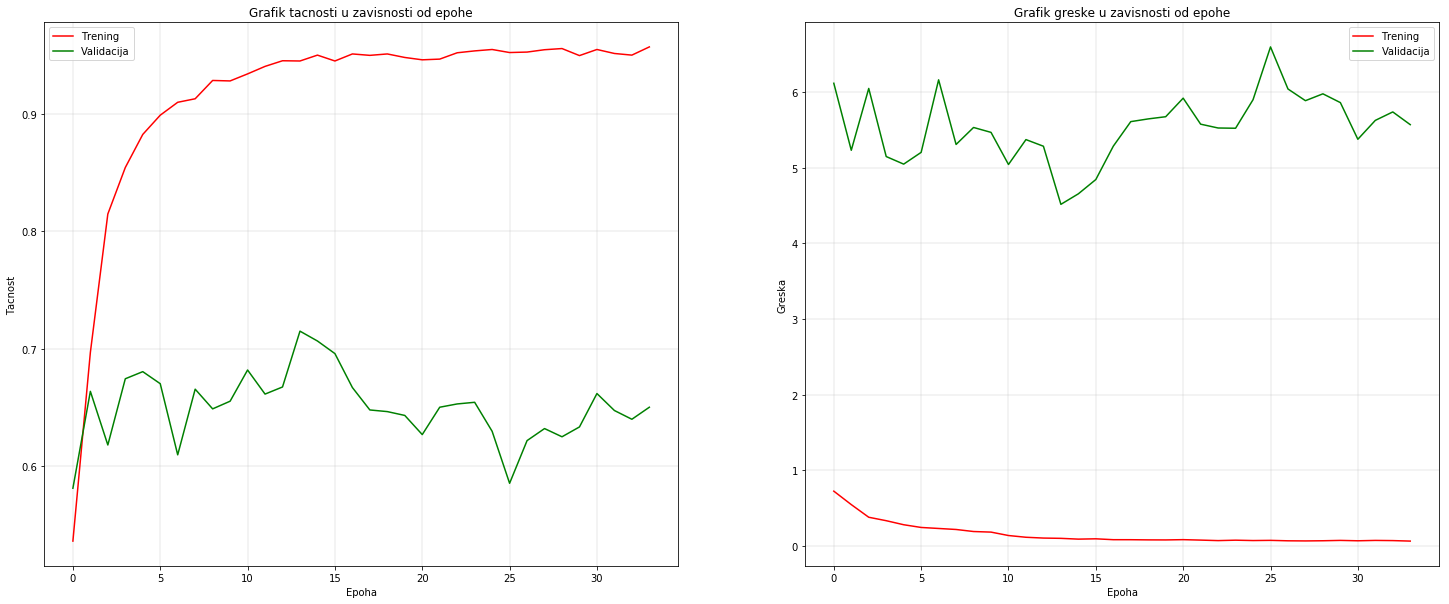

In [0]:
# Iscrtavanje
tacnost = istorija_1.history['acc']
val_tacnost = istorija_1.history['val_acc']
greska = istorija_1.history['loss']
val_greska = istorija_1.history['val_loss']

fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (25, 10))

ax1.set_title ('Grafik tacnosti u zavisnosti od epohe')
ax1.set_xlabel ('Epoha')
ax1.set_ylabel ('Tacnost')
ax1.plot (istorija_1.epoch, tacnost, c = 'r', label = 'Trening')
ax1.plot (istorija_1.epoch, val_tacnost, c = 'g', label = 'Validacija')
ax1.legend ()
ax1.grid (linewidth = 0.3)

ax2.set_title ('Grafik greske u zavisnosti od epohe')
ax2.set_xlabel ('Epoha')
ax2.set_ylabel ('Greska')
ax2.plot (istorija_1.epoch, greska, c = 'r', label = 'Trening')
ax2.plot (istorija_1.epoch, val_greska, c = 'g', label = 'Validacija')
ax2.legend ()
ax2.grid (linewidth = 0.3)

plt.savefig ('Grafici.png')
plt.show()


In [0]:
# Evaluacija modela
greska_trening, tacnost_trening = knn.evaluate(x_trening, y_trening)
greska_test, tacnost_test = knn.evaluate(x_test, y_test)

print(f'Greska modela na trening skupu: {greska_trening}, tacnost: {tacnost_trening}')
print(f'Greska modela na test skupu: {greska_test}, tacnost: {tacnost_test}')


3523/3523 [==============================] - 1s 169us/step
Greska modela na trening skupu: 0.0012655146218339478, tacnost: 0.9998001998001999
Greska modela na test skupu: 0.014436204172292277, tacnost: 0.9965938120919671


In [0]:
# Treniranje modela na celom skupu podataka koriscenjem najboljeg broja epoha dobijenog na osnovu grafika
epohe = 3
vel_grupe = 64
ispis = 0

knn.fit (x = X, y = y, batch_size = vel_grupe, epochs = epohe, verbose = ispis)


In [0]:
# Testiranje za neku originalnu sliku

def izdeli_sliku (put_slike, put_izlaza):
    
    slika = Image.open(put_slike)
    ime_slike = str.split (put_slike, sep = os.path.sep)[-1]
    sir_slike, vis_slike = slika.size
    
    print (ime_slike)
    
    for i in range (0, sir_slike, 64):
        
        for j in range (0, vis_slike, 64):
            
            if i + 64 < sir_slike:
                k = i + 64
            else:
                i = sir_slike - 64 - 1
                k = sir_slike - 1
            
            if j + 64 < vis_slike:
                l = j + 64
            else:
                j = vis_slike - 64 - 1
                l = vis_slike - 1
            
            
            kontura = (i, j, k, l)
            isecak = slika.crop (kontura)
            
            
            try:
              isecak.save (os.path.join(put_izlaza, str.split (ime_slike, sep = '.')[-2] + "_%s_" % str(i) + "%s.jpg" % str(j)))
                
            except:
                print ('Nije uspelo cuvanje slike!')


In [0]:

! rm -R TEST
! rm -R REZULTATI
! mkdir TEST
! mkdir REZULTATI

rm: cannot remove 'TEST': No such file or directory
rm: cannot remove 'REZULTATI': No such file or directory


In [0]:
put_slike = os.path.join ('Hey-Waldo', 'original-images', '7.jpg')
put_izlaza = os.path.join ('TEST')

izdeli_sliku (put_slike, put_izlaza)

7.jpg


In [0]:
test = np.array([np.array(Image.open(os.path.join(put_izlaza, ime_slike))) for ime_slike in os.listdir(put_izlaza)])


In [0]:
niz_rezultata = knn.predict (test, batch_size = 64, verbose = 1)


713/713 [==============================] - 0s 232us/step


In [0]:
put_rezultata = os.path.join ('REZULTATI')

kandidati = []

for i in range (len(niz_rezultata)):
  if niz_rezultata[i] >= 0.5:
    print (i, niz_rezultata[i])
    kandidati.append (Image.fromarray (test[i]))


for i in range (len(kandidati)):
  ime = '%d.jpg' % i
  kandidati[i].save(os.path.join (put_rezultata, ime))


# U nastavku sledi deo koji se odnosi na sugestije dobijene pri prezentovanju projekta

### 1. Slucaj: slike trening skupa na kojima se nalazi Valdo, su dobijene lepljenjem transparentnog Valda a test i validacija sadrze slike Valda na kojima je Valdo u originalnim slikama (ne konstruisan)

In [0]:
! rm -R Hey-Waldo/64/gen_waldo
! mkdir Hey-Waldo/64/gen_waldo

rm: cannot remove 'Hey-Waldo/64/gen_waldo': No such file or directory


In [0]:
# Kreiranje novog skupa za test, koji sadrzi slike Valda iz originalnih slika, ne lepljene slike

osobine_3 = ImageDataGenerator (
        rotation_range = 180,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest')

# Generisemo samo slike walda, jer su klase neizbalansirane
gcolab_putanja_slika_test = os.path.join ('Hey-Waldo', '64')
gcolab_izlaz_test = os.path.join ('Hey-Waldo', '64', 'gen_waldo')

# Cuvam u gen_ direktorijumu
generator_3 = osobine.flow_from_directory(
    directory = gcolab_putanja_slika_test,
    save_to_dir = gcolab_izlaz_test,
    save_prefix = 'gen',
    save_format = 'jpeg',
    target_size = (64, 64),
    color_mode = "rgb",
    batch_size = 4,
    class_mode = 'categorical',
    classes = ['waldo'],
    shuffle = True,
    seed=3
)

granica = 1500  # Optimalna granica

# Pokrenuti ako je potrebno generisati nove slike

for i in range (granica):
    generator_3.next()


Found 39 images belonging to 1 classes.


In [0]:
# Kreiranje test i validacionog skupa

# Koriscenje slika sa generisanim Valdom
y_trening_1 = [1 for i in range(len(valdo))]
y_trening_2 = [0 for i in range(len(ne_valdo))]
y_trening = np.array(y_trening_1 + y_trening_2)

# Koriscenje slika sa organskim Valdom, tj. onim iz originalnih slika za dobijanje test skupa
gcolab_valdo_test = gcolab_izlaz_test
gcolab_ne_valdo_test = os.path.join ('CNN_SLIKE', 'notwaldo', '')

valdo_test = np.array([np.array(plt.imread (gcolab_valdo_test + '/' + ime_slike)) for ime_slike in os.listdir(gcolab_valdo_test)])
ne_valdo_test = np.array([np.array(plt.imread (gcolab_ne_valdo_test + ime_slike)) for ime_slike in os.listdir(gcolab_ne_valdo_test)])

y_test_1 = [1 for i in range(len(valdo_test))]
y_test_2 = [0 for i in range(len(ne_valdo_test))]
y_valid_test = np.array(y_test_1 + y_test_2)


# Deljenje na skupove
x_trening = np.concatenate ((valdo, ne_valdo))

permutacija = np.random.permutation (len(x_trening))

# Shuffle za x_trening i y_trening, mora ovako jer ne koristim train_test_split
x_trening = x_trening[permutacija]
y_trening = y_trening[permutacija]


x_valid_test = np.concatenate ((valdo_test, ne_valdo_test))

x_valid, x_test, y_valid, y_test = ms.train_test_split (x_valid_test, y_valid_test, train_size = 0.5, test_size=0.5, stratify = y_valid_test, random_state = 3)

# Nakon ovog imam skup za trening koji se sastoji iz lepljenih slika Valda
# I dva skupa, validacioni sa originalnim Valdima (naravno i slika bez njih) i isto takav test skup


In [0]:
print ('Duzine svakog od skupova su:')
print ('x_trening:', len (x_trening))
print ('x_valid:', len (x_valid))
print ('x_test:', len (x_test))


Duzine svakog od skupova su:
x_trening: 10674
x_valid: 5593
x_test: 5594


In [0]:
# Kreiranje modela
K.clear_session()

knn_1 = Sequential()

knn_1.add(Conv2D(filters = 32, 
               kernel_size = (2, 2), 
               strides = (1,1),
               padding = 'same',
               input_shape = (64, 64, 3),
               data_format = 'channels_last'))

knn_1.add(Activation('relu'))

knn_1.add(MaxPooling2D(pool_size = (2,2), strides = 2))

knn_1.add(Dropout(0.3))

knn_1.add(Conv2D(filters = 64,
               kernel_size = (2,2),
               strides = (1,1),
               padding = 'valid'))

knn_1.add(Activation('relu'))

knn_1.add(MaxPooling2D(pool_size = (2,2), strides = 2))

knn_1.add(Flatten())

knn_1.add(Dense(64))

knn_1.add(Activation('relu'))

knn_1.add(Dropout(0.3))

knn_1.add(Dense(1))

knn_1.add(Activation('sigmoid'))

knn_1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
__________

In [0]:
# Treniranje modela
epohe = 1000
vel_grupe = 64
ispis = 0
cekanje = 20
putanja = os.path.join ('Cekpointi', 'M2_cekpoint_epoha_{epoch:02d}__val_greska_{val_loss:.2f}.hdf5')
kolbekovi = [EarlyStopping (patience = cekanje), ModelCheckpoint (putanja, save_best_only = True)]

knn_1.compile (optimizer = Adam(lr=0.00075), loss='binary_crossentropy', metrics=['acc'])

istorija_2 = knn_1.fit (x = x_trening, y = y_trening, batch_size = vel_grupe, epochs = epohe, verbose = ispis, validation_data = (x_valid, y_valid), callbacks = kolbekovi)


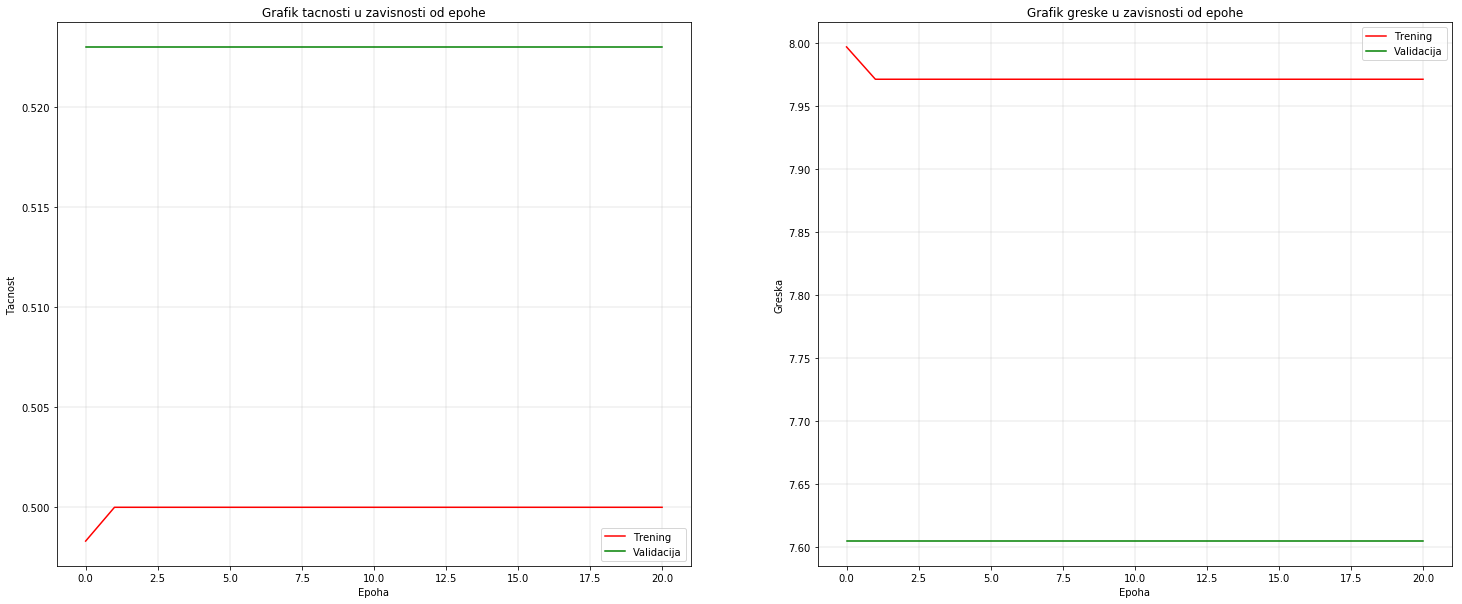

In [0]:
# Iscrtavanje
tacnost = istorija_2.history['acc']
val_tacnost = istorija_2.history['val_acc']
greska = istorija_2.history['loss']
val_greska = istorija_2.history['val_loss']

fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (25, 10))

ax1.set_title ('Grafik tacnosti u zavisnosti od epohe')
ax1.set_xlabel ('Epoha')
ax1.set_ylabel ('Tacnost')
ax1.plot (istorija_2.epoch, tacnost, c = 'r', label = 'Trening')
ax1.plot (istorija_2.epoch, val_tacnost, c = 'g', label = 'Validacija')
ax1.legend ()
ax1.grid (linewidth = 0.3)

ax2.set_title ('Grafik greske u zavisnosti od epohe')
ax2.set_xlabel ('Epoha')
ax2.set_ylabel ('Greska')
ax2.plot (istorija_2.epoch, greska, c = 'r', label = 'Trening')
ax2.plot (istorija_2.epoch, val_greska, c = 'g', label = 'Validacija')
ax2.legend ()
ax2.grid (linewidth = 0.3)

plt.savefig ('Grafici_2.png')
plt.show()


In [0]:
# Evaluacija modela
greska_trening, tacnost_trening = knn_1.evaluate(x_trening, y_trening)
greska_test, tacnost_test = knn_1.evaluate(x_test, y_test)

print(f'Greska modela na trening skupu: {greska_trening}, tacnost: {tacnost_trening}')
print(f'Greska modela na test skupu: {greska_test}, tacnost: {tacnost_test}')


5594/5594 [==============================] - 1s 170us/step
Greska modela na trening skupu: 7.971192827558884, tacnost: 0.5
Greska modela na test skupu: 7.606404580684658, tacnost: 0.522881658952237


### 2. Slucaj: slike trening skupa na kojima se nalazi Valdo, su dobijene lepljenjem transparentnog Valda, validacija sadrze slike Valda koje su takodje generisane, test sadrzi organske slike

In [0]:
# Kreiranje test i validacionog skupa

# Koriscenje slika sa generisanim Valdom
y_trening_1 = [1 for i in range(len(valdo))]
y_trening_2 = [0 for i in range(len(ne_valdo))]
y_trening_valid = np.array(y_trening_1 + y_trening_2)

# Koriscenje slika sa organskim Valdom, tj. onim iz originalnih slika za dobijanje test skupa
gcolab_valdo_test = gcolab_izlaz_test
gcolab_ne_valdo_test = os.path.join ('CNN_SLIKE', 'notwaldo', '')

valdo_test = np.array([np.array(plt.imread (gcolab_valdo_test + '/' + ime_slike)) for ime_slike in os.listdir(gcolab_valdo_test)])
ne_valdo_test = np.array([np.array(plt.imread (gcolab_ne_valdo_test + ime_slike)) for ime_slike in os.listdir(gcolab_ne_valdo_test)])

y_test_1 = [1 for i in range(len(valdo_test))]
y_test_2 = [0 for i in range(len(ne_valdo_test))]
y_test = np.array(y_test_1 + y_test_2)


# Deljenje na skupove
x_trening_valid = np.concatenate ((valdo, ne_valdo))
x_test = np.concatenate ((valdo_test, ne_valdo_test))

permutacija = np.random.permutation (len(x_test))

# Shuffle za x_test i y_test, mora ovako jer ne koristim train_test_split
x_test = x_test[permutacija]
y_test = y_test[permutacija]

x_trening, x_valid, y_trening, y_valid = ms.train_test_split (x_trening_valid, y_trening_valid, train_size = 0.67, test_size=0.33, stratify = y_trening_valid, random_state = 3)

# Nakon ovog imam skup za trening koji se sastoji iz lepljenih slika Valda i isti takav validacioni
# I test sa originalnim Valdima (naravno i slika bez njih)


In [0]:
print ('Duzine svakog od skupova su:')
print ('x_trening:', len (x_trening))
print ('x_valid:', len (x_valid))
print ('x_test:', len (x_test))


# Test skup je malo veci, te ga smanjujemo
x_test = x_test[ : 3000]
y_test = y_test[ : 3000]


Duzine svakog od skupova su:
x_trening: 7151
x_valid: 3523
x_test: 11187


In [0]:
# Kreiranje modela
K.clear_session()

knn_2 = Sequential()

knn_2.add(Conv2D(filters = 32, 
               kernel_size = (2, 2), 
               strides = (1,1),
               padding = 'same',
               input_shape = (64, 64, 3),
               data_format = 'channels_last'))

knn_2.add(Activation('relu'))

knn_2.add(MaxPooling2D(pool_size = (2,2), strides = 2))

knn_2.add(Dropout(0.3))

knn_2.add(Conv2D(filters = 64,
               kernel_size = (2,2),
               strides = (1,1),
               padding = 'valid'))

knn_2.add(Activation('relu'))

knn_2.add(MaxPooling2D(pool_size = (2,2), strides = 2))

knn_2.add(Flatten())

knn_2.add(Dense(64))

knn_2.add(Activation('relu'))

knn_2.add(Dropout(0.3))

knn_2.add(Dense(1))

knn_2.add(Activation('sigmoid'))

knn_2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
__________

In [0]:
# Treniranje modela
epohe = 1000
vel_grupe = 64
ispis = 0
cekanje = 20
putanja = os.path.join ('Cekpointi', 'M2_cekpoint_epoha_{epoch:02d}__val_greska_{val_loss:.2f}.hdf5')
kolbekovi = [EarlyStopping (patience = cekanje), ModelCheckpoint (putanja, save_best_only = True)]

knn_2.compile (optimizer = Adam(lr=0.00075), loss='binary_crossentropy', metrics=['acc'])

istorija_3 = knn_2.fit (x = x_trening, y = y_trening, batch_size = vel_grupe, epochs = epohe, verbose = ispis, validation_data = (x_valid, y_valid), callbacks = kolbekovi)


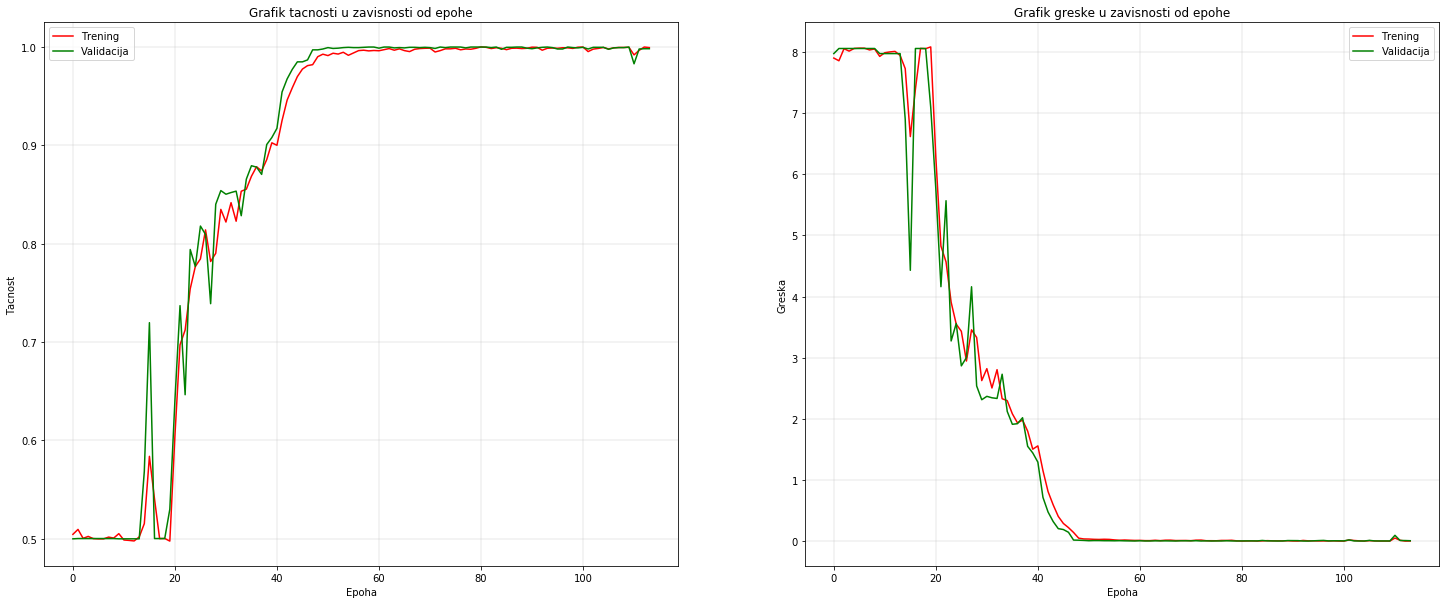

In [0]:
# Iscrtavanje
tacnost = istorija_3.history['acc']
val_tacnost = istorija_3.history['val_acc']
greska = istorija_3.history['loss']
val_greska = istorija_3.history['val_loss']

fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (25, 10))

ax1.set_title ('Grafik tacnosti u zavisnosti od epohe')
ax1.set_xlabel ('Epoha')
ax1.set_ylabel ('Tacnost')
ax1.plot (istorija_3.epoch, tacnost, c = 'r', label = 'Trening')
ax1.plot (istorija_3.epoch, val_tacnost, c = 'g', label = 'Validacija')
ax1.legend ()
ax1.grid (linewidth = 0.3)

ax2.set_title ('Grafik greske u zavisnosti od epohe')
ax2.set_xlabel ('Epoha')
ax2.set_ylabel ('Greska')
ax2.plot (istorija_3.epoch, greska, c = 'r', label = 'Trening')
ax2.plot (istorija_3.epoch, val_greska, c = 'g', label = 'Validacija')
ax2.legend ()
ax2.grid (linewidth = 0.3)

plt.savefig ('Grafici_2.png')
plt.show()


In [0]:
# Evaluacija modela
greska_trening, tacnost_trening = knn_2.evaluate(x_trening, y_trening)
greska_test, tacnost_test = knn_2.evaluate(x_test, y_test)

print(f'Greska modela na trening skupu: {greska_trening}, tacnost: {tacnost_trening}')
print(f'Greska modela na test skupu: {greska_test}, tacnost: {tacnost_test}')


3000/3000 [==============================] - 0s 148us/step
Greska modela na trening skupu: 0.0003484760621138279, tacnost: 1.0
Greska modela na test skupu: 6.049858510335286, tacnost: 0.487


**Mogu se na dalje ispitivati slucajevi kada imam mesane skupove za trening, validaciju i test, tj. da svaki od njih sadrzi i Valde koji su generisani i one koji nisu. Ne ocekujem neko znatno poboljsanje, jer tada mesam dve razlicite stvari. Moze se dobiti poboljsanje ako bih transparentnim Valdima smanjio kvalitet pre lepljenja (kako je kolega Nemanja predlozio) pa onda takve slike koristio ali to su sad sve finese koje ce malo po malo poboljsavati tacnost, ali ne u nekoj meri da mozemo reci da je model dovoljno dobar.**